# Classifier of face features based on latent activations

1. Collect activations of latent for each sample from the dataset 
2. Load df with face features assigned to each sample
3. Create classifiers
4. From the weights of classifiers find which feature does each latent activate for the most

## Preliminaries

In [1]:
import os
from copy import deepcopy

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sae.sae import EncoderOutput

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

Triton not installed, using eager implementation of SAE decoder.


In [2]:
from notebooks.utils import load_sae, load_diffusion, get_diffusion_params

In [3]:
from notebooks.utils import get_error, get_image, array_to_dict, add_error

In [4]:
path = "weights2weights/weights_datasets"
device = "cuda"

In [5]:
sae_path = "runs/run_lat5000_bs512_auxk0.03_k256_epoch10_1381189_0/0"
sae = load_sae(sae_path)

In [6]:
base_weights, pipe = load_diffusion()
prompt, ddim_steps, guidance_scale, negative_prompt, latents = get_diffusion_params(pipe)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/peft/tuners/lora/model.py:364: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  return getattr(self.model, name)


## Collect activations

In [ ]:
!python notebooks/collect_activations.py

In [7]:
activations = torch.load(f"{path}/activations_crosscoder.pt")

## Face features df

In [8]:
df = torch.load(f"{path}/identities/identity_df.pt")
df["filename"] = df.index.str.split(".").str[0]

## Classifiers

In [9]:
filenames = list(activations.keys())
X = torch.stack([activations[f] for f in filenames]).cpu().numpy()

filenames = [os.path.splitext(f)[0] for f in filenames]
df = df.loc[df.filename==filenames]
df.shape

(64974, 42)

In [10]:
y_cols = df.drop(columns=["filename", "identity"]).columns
Y = df[y_cols].values 
Y

array([[-1,  1,  1, ..., -1, -1,  1],
       [ 1, -1,  1, ..., -1, -1,  1],
       [ 1,  1, -1, ..., -1, -1,  1],
       ...,
       [-1, -1,  1, ..., -1, -1,  1],
       [-1,  1,  1, ..., -1, -1,  1],
       [-1,  1,  1, ..., -1, -1,  1]])

##### Calculate

In [92]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.20797548, -0.01800251, -0.49118048, ..., -0.06893195,
        -0.01362965, -0.22831415],
       [-0.9618997 , -0.01800251, -0.49118048, ..., -0.06893195,
        -0.01362965, -0.22831415],
       [-0.4600346 , -0.01800251, -0.33795696, ..., -0.06893195,
        -0.01362965, -0.22831415],
       ...,
       [-0.9618997 , -0.01800251,  0.20617703, ..., -0.06893195,
        -0.01362965, -0.22831415],
       [ 0.85544086, -0.01800251,  1.2862419 , ..., -0.06893195,
        -0.01362965, -0.22831415],
       [ 1.4037321 , -0.01800251, -0.49118048, ..., -0.06893195,
        -0.01362965,  0.2686712 ]], dtype=float32)

In [93]:
pinverse = torch.pinverse(torch.tensor(X).to(device))

In [94]:
torch.save(scaler, "notebooks/scaler.pt")
torch.save(pinverse, "notebooks/pinverse.pt")

##### Load

In [11]:
scaler = torch.load("notebooks/scaler.pt")
pinverse = torch.load("notebooks/pinverse.pt")

X = scaler.transform(X)

### LSTSQ with pinverse

In [12]:
directions = (pinverse.cpu()@Y)

### Logistic Regression

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [39]:
classifiers = {}

for i, col in enumerate(y_cols):
    if col not in ("Bushy_Eyebrows", "Young"):
        continue
    clf = LogisticRegression(max_iter=10, class_weight="balanced", random_state=42)
    if len(set(Y_train[:, i])) ==2:
        clf.fit(X_train, Y_train[:, i])
        classifiers[col] = clf
    else:
        print(f"{len(set(Y_train[:, i]))} classes for {col}")

/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [40]:
for col, clf in classifiers.items():
    Y_pred = clf.predict(X_test)
    acc = balanced_accuracy_score(Y_test[:, y_cols.get_loc(col)], Y_pred)
    print(f"{col} Accuracy: {acc:.4f}")

Bushy_Eyebrows Accuracy: 0.8240
Young Accuracy: 0.8600


### Testing one feature

#### Get base lora sample

In [13]:
i = 6

In [14]:
sample = torch.load(path + '/single/0/'+ df.index[i].replace('jpg', 'pt'))

In [15]:
err, gt_weights, rec_weights = get_error(sae, sample, base_weights, True)

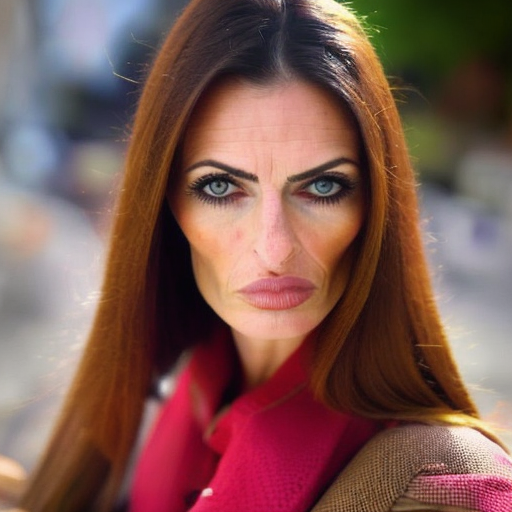

In [16]:
get_image(gt_weights, pipe, prompt, 50, guidance_scale, negative_prompt,latents)

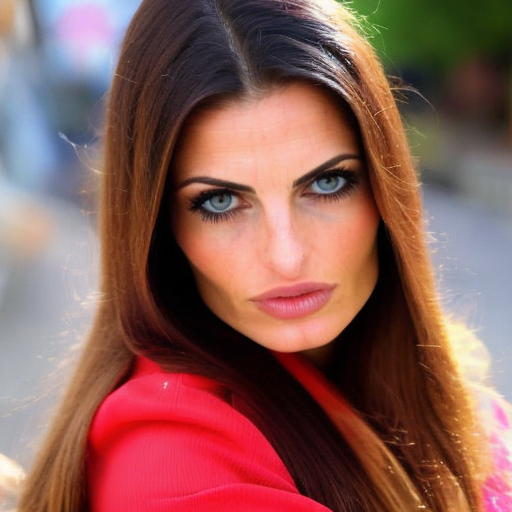

In [17]:
get_image(rec_weights, pipe, prompt, ddim_steps, guidance_scale, negative_prompt,latents)

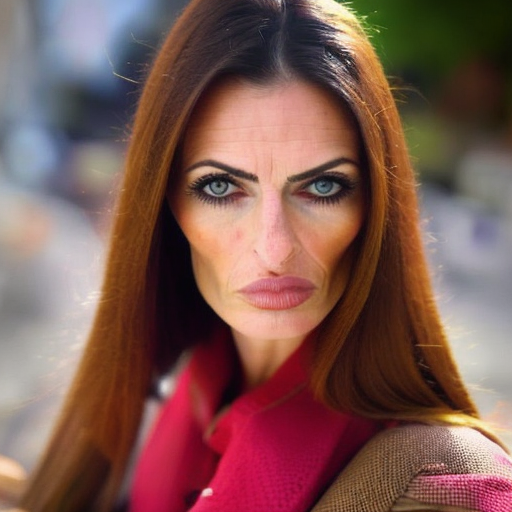

In [18]:
get_image(add_error(err, rec_weights) ,pipe, prompt, ddim_steps, guidance_scale, negative_prompt,latents)

#### Use logistic

In [48]:
classifiers.keys()

dict_keys(['Bushy_Eyebrows', 'Young'])

In [ ]:
col = "Young"
clf = classifiers[col]

'Young'

In [385]:
torch.save(clf, "notebooks/clf_bushy.pt")

In [256]:
w = clf.coef_.flatten()
b = clf.intercept_ 

x = X[4]

eta = -2
x_modified = x + eta * w

In [257]:
i = np.abs(w).argsort()[-10:]
i

array([3674, 4556, 4093, 4928, 2274, 2912,  372, 4875, 1459, 4471])

In [258]:
w[i]

array([-0.1169388 , -0.12316422, -0.12377257, -0.12466548, -0.12653796,
       -0.12840635, -0.13482812, -0.16291693, -0.17501989, -0.1756691 ])

In [259]:
dir_bush[i]

tensor([-0.0012, -0.0060,  0.0008,  0.0005, -0.0007, -0.0091,  0.0064, -0.0228,
        -0.0054, -0.0107], dtype=torch.float64)

In [270]:
x_modified_2 = x.copy()
x_modified_2[i] = x_modified_2[i] -90*w[i]

x_modified_3 = x.copy()
x_modified_3[i] = x_modified_3[i] -400*dir_bush[i].cpu().numpy()

In [271]:
z = np.dot(w, x) + b
predicted_label = 1 if z > 0 else 0
print(predicted_label)
z_modified = np.dot(w, x_modified) + b
predicted_label = 1 if z_modified > 0 else 0
print(predicted_label)
z_modified = np.dot(w, x_modified_2) + b
predicted_label = 1 if z_modified > 0 else 0
print(predicted_label)
z_modified = np.dot(w, x_modified_3) + b
predicted_label = 1 if z_modified > 0 else 0
print(predicted_label)

1
0
0
1


In [272]:
x_new = scaler.inverse_transform(x_modified.reshape(1,-1))
x_new2 = scaler.inverse_transform(x_modified_2.reshape(1,-1))
x_new3 = scaler.inverse_transform(x_modified_3.reshape(1,-1))
x_orig = scaler.inverse_transform(x.reshape(1,-1))

In [273]:
in_x = x_orig
acts= torch.tensor(in_x[0])
##
k = 1000
indices = acts.topk(k).indices
acts = torch.tensor(x_new2[0])[indices] 
##

e2 = EncoderOutput(top_acts=acts.to(device),
                    top_indices=indices.to(device))

  0%|          | 0/50 [00:00<?, ?it/s]

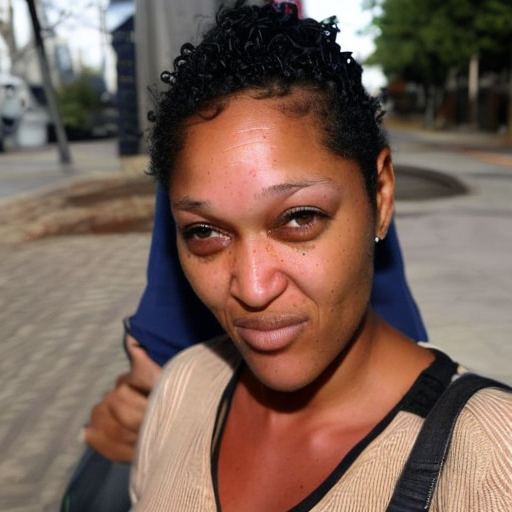

In [274]:
weights_out = sae.decode(e2.top_acts, e2.top_indices)
weights_out = array_to_dict(weights_out, base_weights)
get_image(add_error(err, weights_out), pipe, prompt, ddim_steps, guidance_scale, negative_prompt,latents)

#### Use direction

In [19]:
x = X[i] # sample
x.shape

(5000,)

In [20]:
n = 13
d = directions[:, n].cpu().numpy()
d.shape, y_cols[n]

((5000,), 'Chubby')

In [36]:
# Strongest directions
p = np.percentile(abs(d), 99.99)
above_p = np.where(np.abs(d) > p)[0]
above_p

array([2755])

In [49]:
mod_dir = d.copy()
mod_dir[above_p] = 5000*d[above_p]

In [50]:
x_mod = x.copy()
x_mod = x_mod + mod_dir

In [51]:
x_orig = scaler.inverse_transform(x.copy().reshape(1,-1))
x_mod = scaler.inverse_transform(x_mod.reshape(1,-1))

x.mean(), sample.mean(), x_orig.mean(), x_mod.mean()

(0.011434345,
 tensor(-4.4171e-05, device='cuda:0'),
 0.0028294064,
 0.002631324455519704)

In [52]:
k = 256
acts= torch.tensor(abs(x_mod)).squeeze(0)

indices = acts.topk(k).indices
acts = torch.tensor(x_mod)[:, indices].squeeze()

e2 = EncoderOutput(top_acts=acts.to(device),
                    top_indices=indices.to(device))

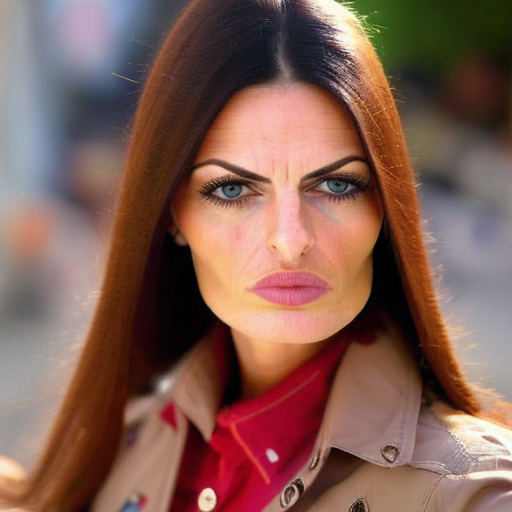

In [53]:
weights_out = sae.decode(e2.top_acts, e2.top_indices)
weights_out = array_to_dict(weights_out, base_weights)
get_image(add_error(err, weights_out), pipe, prompt, ddim_steps, guidance_scale, negative_prompt,latents)

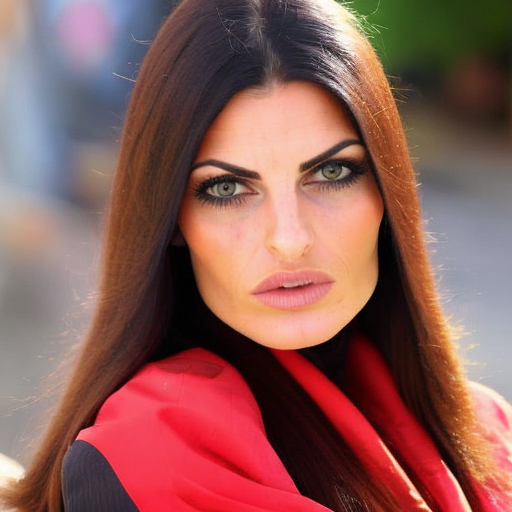

In [54]:
get_image(weights_out, pipe, prompt, ddim_steps, guidance_scale, negative_prompt,latents)